In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import math
import matplotlib
import matplotlib.pyplot as plt
from cvxpy import *
from tqdm import tqdm

from scipy.spatial import ConvexHull
from scipy.optimize import fsolve, linprog
from numpy.linalg import norm, inv, matrix_power
from scipy.integrate import simps
from scipy.linalg import sqrtm, svd

In [2]:
''' Helper Functions '''
def stochastic_matrix(n, m):
    matrix = np.random.rand(n,m)
    return matrix/np.sum(matrix)
def marginalize(P, axis):
    if axis == 'x':
        return np.sum(P, 1)
    elif axis == 'y':
        return np.sum(P, 0)
    else:
        print('Error #1')
        return

def PIC(P_XY, P_X, P_Y):
    D_X_sqrtinv, D_Y_sqrtinv = np.diag(P_X**(-.5)), np.diag(P_Y**(-.5))
    #D_X_sqrtinv, D_Y_sqrtinv = sqrtm(inv(D_X)), sqrtm(inv(D_Y))
    Q = np.matmul(np.matmul(D_X_sqrtinv, P_XY), D_Y_sqrtinv)
    U, S, V = svd(Q)
    f, g = np.matmul(D_X_sqrtinv, U), np.matmul(D_Y_sqrtinv, V.transpose())
    pic = np.sqrt(S)
    return pic, f, g

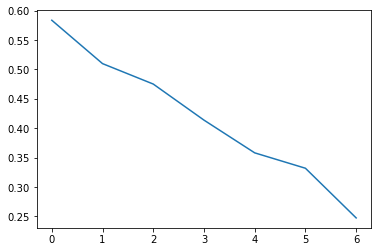

In [3]:
n_x = 10
n_y = 8
P_XY = stochastic_matrix(n_x,n_y)
P_X = P_XY.sum(axis=1)
P_Y = P_XY.sum(axis=0)

pic, f, g = PIC(P_XY,P_X,P_Y)
plt.plot(range(len(pic)-1),pic[1:])

In [4]:
# Generate samples

# number of dimensions and points
n_f = 3
F = f[:,1:n_f+1]

# generate samples
nsamples = 10**3

# initialize matrix A
A = np.zeros((n_f,nsamples))

for i in tqdm(range(nsamples)):
    # produce samples
    ###### TODO: improve this sampling procedure ######    
    a = 5*(2*np.random.rand(n_f,1)-1)
    
    # check if feasible resample
    while (F.dot(a)).min()< -1:
        a = 10*(2*np.random.rand(n_f,1)-1)
    
    A[:,i] = a[:,0]
    ##############################################



100%|██████████| 1000/1000 [01:02<00:00, 16.01it/s]


(array([   5.,   19.,   26.,   42.,   86.,  138.,  194.,  226.,  306.,
         341.,  296.,  287.,  312.,  251.,  206.,  148.,   67.,   23.,
          21.,    6.]),
 array([-0.97990174, -0.88774955, -0.79559736, -0.70344517, -0.61129298,
        -0.51914079, -0.4269886 , -0.33483641, -0.24268422, -0.15053202,
        -0.05837983,  0.03377236,  0.12592455,  0.21807674,  0.31022893,
         0.40238112,  0.49453331,  0.5866855 ,  0.67883769,  0.77098988,
         0.86314207]),
 <a list of 20 Patch objects>)

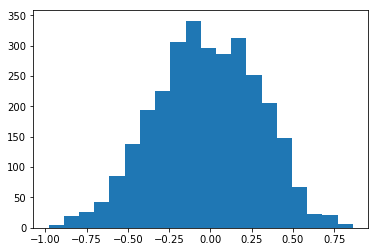

In [5]:
# check values of A that we are obtaining
plt.hist(A.flatten(),bins=20)

In [6]:
# check feasibility

# produce constraints
w = Variable(nsamples,1)
constraints = []
constraints.append(w>=0)
constraints.append(sum(w)==1.0)
constraints.append(A*w==0.0)

# produce random cost function
### !! Substitute this by true cost !!  ###
c = np.random.rand(nsamples,1)
################################

# construct cvxpy optimization probem
obj = Maximize(c.transpose()*w)
prob = Problem(obj, constraints)

In [7]:
prob.solve()

# optimal value
optval = prob.value

# produce optimal points
wv = w.value

# keep only values with significant contributions
significant_index = np.ravel(wv >1e-8)

Asig = A[:,significant_index]
P_W = np.ravel(wv[significant_index])

# normalize to avoid numerical issues
P_W = P_W/sum(P_W)

# P_{X|W} (g is for given)
P_XgW = np.diag(P_X).dot(1+F.dot(Asig))

# Produce joint distribution
P_XW = P_XgW.dot(np.diag(P_W))

# produce mapping from X to W
P_WgX = np.diag(P_X**(-1)).dot(P_XW)

In [8]:
optval

0.993935853892752

In [15]:
P_WgX

array([[ 0.39436478,  0.4261219 ,  0.16040669,  0.01910663],
       [ 0.13416274,  0.44731632,  0.09264201,  0.32587893],
       [ 0.78928524,  0.09024422,  0.04668725,  0.07378329],
       [ 0.12344291,  0.25240394,  0.00626911,  0.61788404],
       [ 0.47821141,  0.12859518,  0.04873707,  0.34445633],
       [ 0.20735974,  0.12221033,  0.06416859,  0.60626134],
       [ 0.15543029,  0.34289202,  0.06578446,  0.43589323],
       [ 0.20624714,  0.43845615,  0.23328942,  0.12200729],
       [ 0.33097242,  0.45427535,  0.02528418,  0.18946805],
       [ 0.42373069,  0.4674307 ,  0.10557462,  0.00326399]])